In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
title_genres_data_dir = r'../data/csv/title_genres_v2.csv'
title_studios_data_dir = r'../data/csv/title_studios_preprocessed.csv'
title_voice_actors_data_dir = r'../data/csv/title_voice_actors.csv'
title_single_valued_attrs = r'../data/csv/title_single_valued_attrs.csv'

In [3]:
def attr1_count(title_attr_csv_dir, attr_num, barchart = False):
    title_attr_df = pd.read_csv(title_attr_csv_dir, encoding = "utf8")
    attr_anime_count = title_attr_df.sum(axis = 0, numeric_only =True)
    popular_attr = attr_anime_count.nlargest(attr_num)
    popular_attr_list = popular_attr.index.tolist()
    if 'few_production_studio' in popular_attr_list:
        print(True)
        popular_attr = attr_anime_count.nlargest(attr_num+1)
        popular_attr.drop('few_production_studio', inplace = True)
        popular_attr_list = popular_attr.index.tolist()
    attr_anime_dict = {}
    for attr in popular_attr_list:
        attr_anime_dict[attr] = title_attr_df.loc[title_attr_df[attr] == 1]['title'].tolist()

    if barchart:
        ax = popular_attr.plot.bar(x = attr, y = 'Anime', rot = 75)
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.02))

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
    
    return attr_anime_dict

In [4]:
def attr1_attr2_count(attr1_anime_dict, attr2_anime_dict, heatmap = False):
    attr1_attr2_dict = {}
    for attr2, anime_list2 in attr2_anime_dict.items():
        attr1_attr2_dict[attr2] = {}
        for attr1, anime_list1 in attr1_anime_dict.items():
            attr1_attr2_dict[attr2][attr1] = len([i for i in anime_list1 if i in anime_list2])    

    if heatmap:
        attr1_attr2_df = pd.DataFrame.from_dict(attr1_attr2_dict)
        sns.heatmap(data = attr1_attr2_df, annot = True, fmt = 'g')
        plt.xticks(fontsize=14,rotation = 80)
        plt.yticks(fontsize=14)
    
    return attr1_attr2_dict

In [5]:
def avg_score(attr1_anime_dict, attr2_anime_dict, heatmap= False):
    title_score_df = pd.read_csv(title_single_valued_attrs, encoding = "utf8", low_memory = False)[['title','weighted_score_anilist']]

    attr1_attr2_dict = {}
    for attr2, anime_list2 in attr2_anime_dict.items():
        attr1_attr2_dict[attr2] = {}
        for attr1, anime_list1 in attr1_anime_dict.items():
            animes = [anime for anime in anime_list1 if anime in anime_list2] 
            avg_score = title_score_df.loc[title_score_df['title'].isin(animes)]['weighted_score_anilist'].mean()

            if avg_score == avg_score: # not NaN
                attr1_attr2_dict[attr2][attr1] = round(avg_score*10,2)
            else: # is NaN
                attr1_attr2_dict[attr2][attr1] = -1
                
    if heatmap:
        attr1_attr2_df = pd.DataFrame.from_dict(attr1_attr2_dict)

        sns.heatmap(data = attr1_attr2_df, annot = True, fmt = 'g')
        plt.xticks(fontsize=14,rotation = 80)
        plt.yticks(fontsize=14)
    
    return attr1_attr2_dict

In [6]:
from math import log
def successful_score(anime_count_dict, avg_score_dict, heatmap = False):
    attr1_attr2_dict = {}
    for attr2 in anime_count_dict.keys():
        attr1_attr2_dict[attr2] = {}
        for attr1 in anime_count_dict[attr2].keys():
            anime_count = anime_count_dict[attr2][attr1]
            avg_score = avg_score_dict[attr2][attr1]
            if anime_count ==0 or avg_score == -1:
                attr1_attr2_dict[attr2][attr1] = 0
            else:
                beta = 3
                beta_sqr = beta*beta
                anime_count = log(anime_count,2)
                attr1_attr2_dict[attr2][attr1] = round(
                    ((1+beta_sqr)* anime_count * avg_score) / 
                    ((beta_sqr* anime_count + avg_score))
                    ,2)
    
    if heatmap:
        attr1_attr2_df = pd.DataFrame.from_dict(attr1_attr2_dict)

        sns.heatmap(data = attr1_attr2_df, annot = True, fmt = 'g')
        plt.xticks(fontsize=14,rotation = 80)
        plt.yticks(fontsize=14)
        
    return attr1_attr2_dict

## Genres

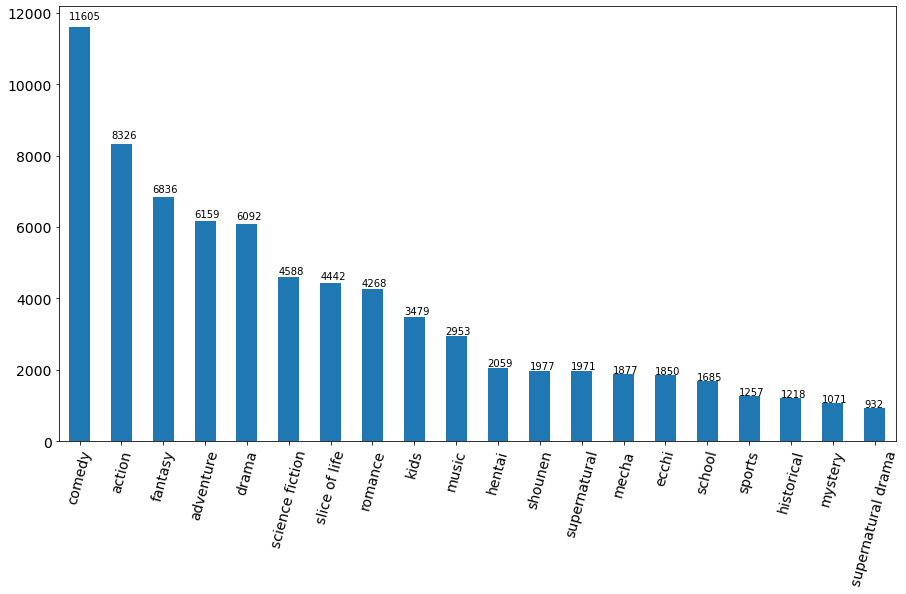

In [7]:
fig = plt.figure(figsize = (15,8))
genre_anime_dict = attr1_count(title_genres_data_dir, 20, barchart = True)
plt.savefig('plots/BarChartMostPopularGenres.png', bbox_inches = "tight")
plt.show()

## Studios

True


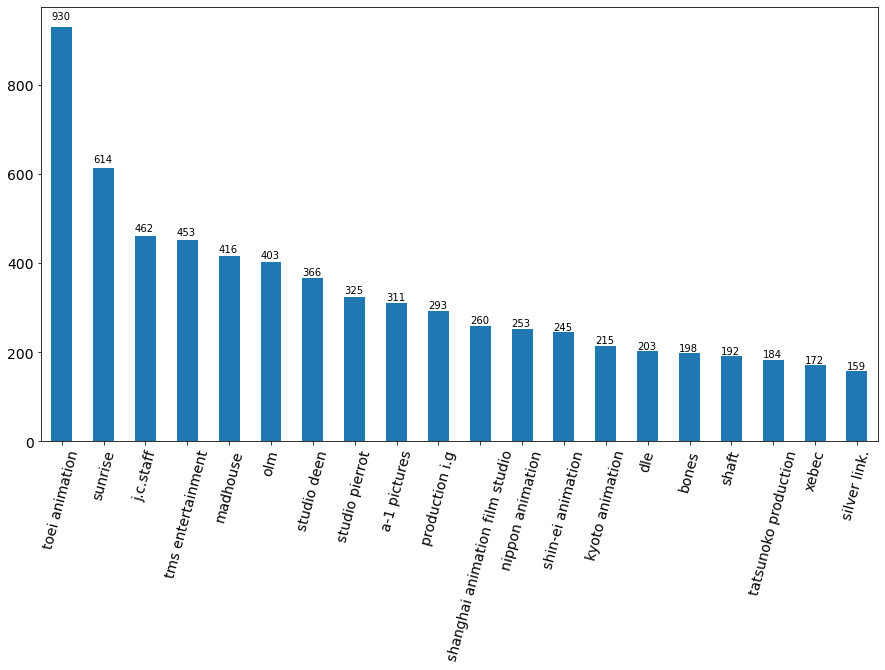

In [8]:
fig = plt.figure(figsize = (15,8))
studio_anime_dict = attr1_count(title_studios_data_dir, 20, barchart = True)
plt.savefig('plots/BarChartMostPopularStudios.png', bbox_inches = "tight")
plt.show()

## Voice actors

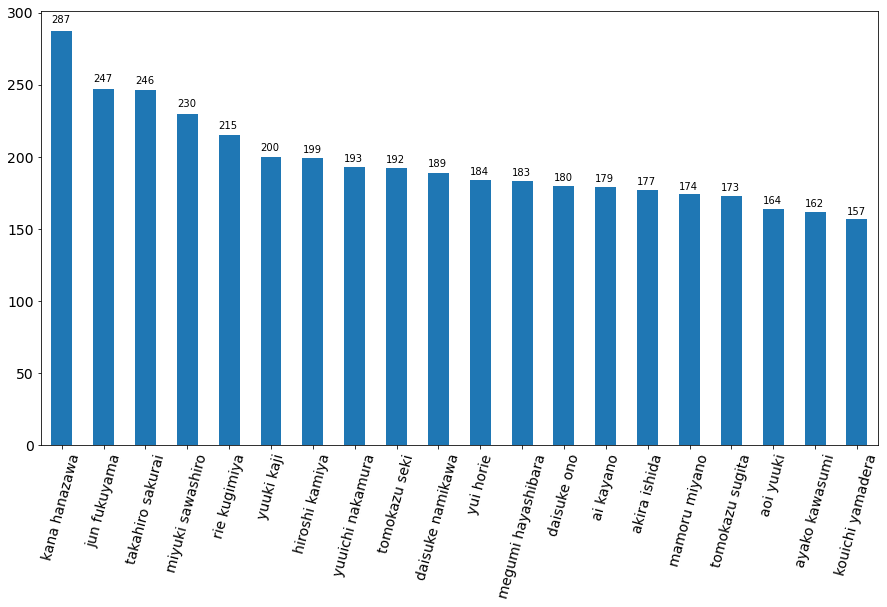

In [9]:
fig = plt.figure(figsize = (15,8))
actor_anime_dict = attr1_count(title_voice_actors_data_dir, 20, barchart = True)
plt.savefig('plots/BarChartMostVoiceActors.png', bbox_inches = "tight")
plt.show()

# Occurence Heatmaps

## Genres vs studio

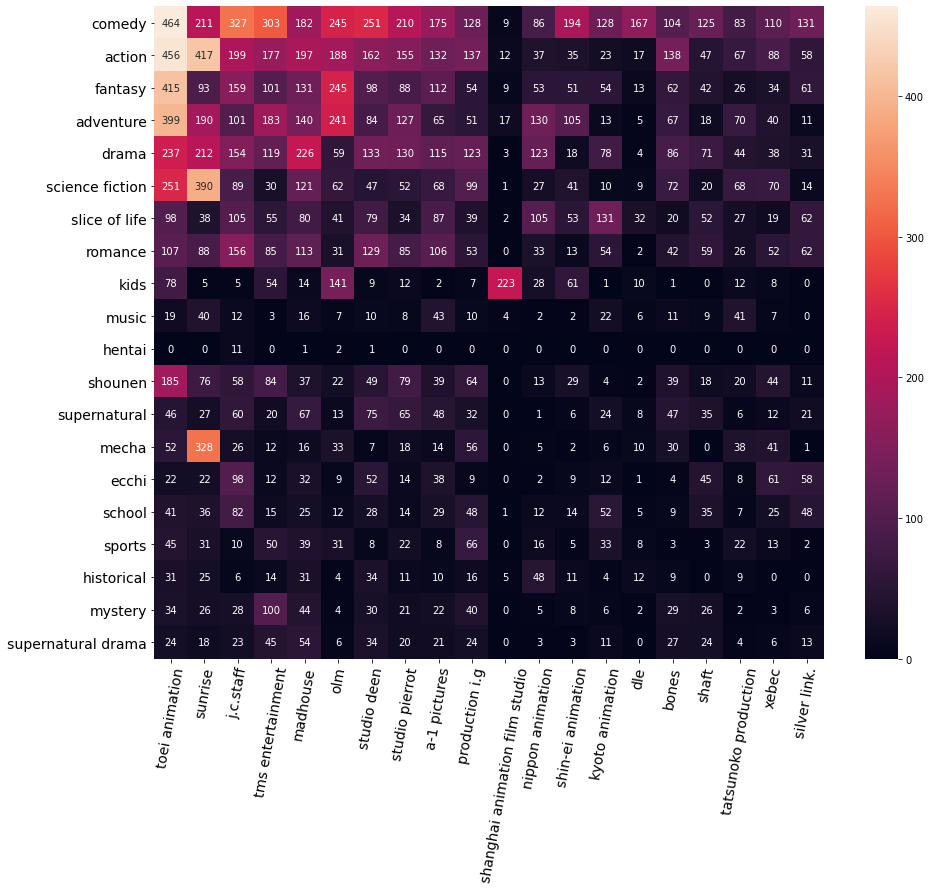

In [10]:
fig = plt.figure(figsize = (15,12))
genre_studio_occurence = attr1_attr2_count(genre_anime_dict, studio_anime_dict, heatmap = True)
plt.savefig('plots/OccurenceHeatmapGenreVsStudio.png', bbox_inches = "tight")
plt.show()

## Remarks

#### Genre:
* Comedy is the most popular genre (barchart), and also is the focus of most big studios (occurence heatmap)
* Big studios don't make hentai. Ecchi, on the other hand, is not avoided.
* Eventhough it is a common belief that anime are for children, the kids genre shows that it is not the most popular genre. Furthermore, there are only a few studios that focus on making anime that target child audiences. 
#### Studio's specialization:
* Shanghai studio: kid
* Sunrise: Mecha, sci-fi, military, action => Fighting robots
* Kyoani: Slice of life, school, romance, drama, comedy - but not shoujo (girl's anime)! 
* dle studio: Comedic parody


## Actors vs studios

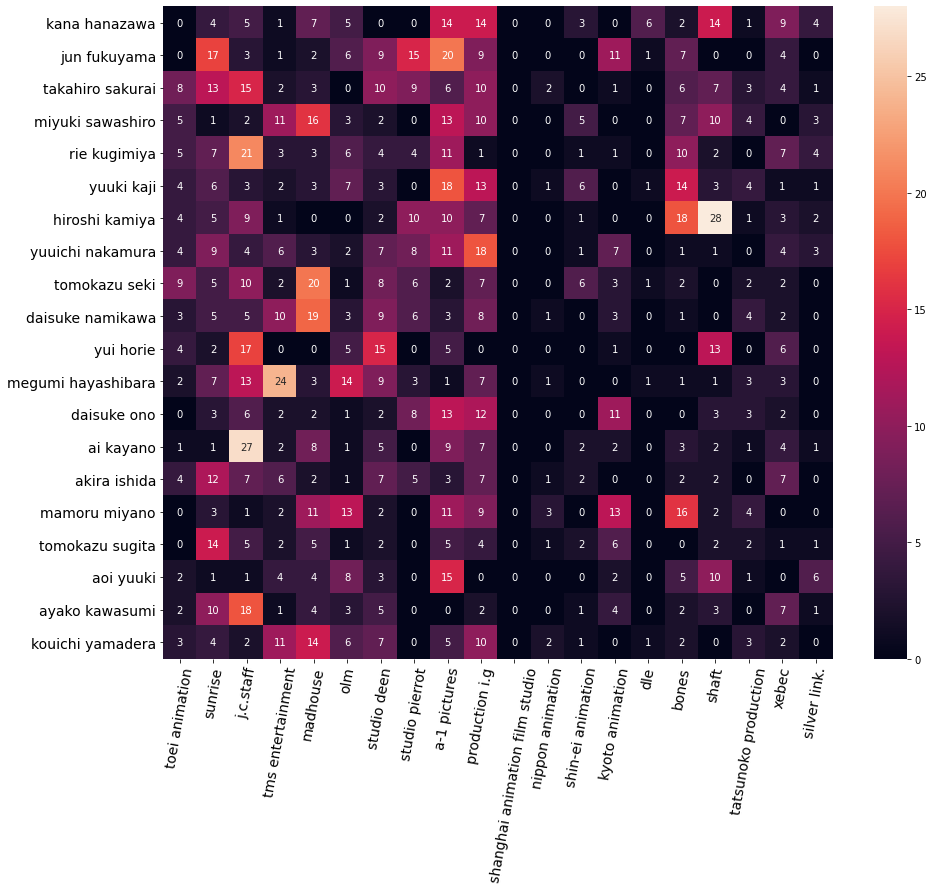

In [11]:
fig = plt.figure(figsize = (15,12))
actor_studio_occurence = attr1_attr2_count( actor_anime_dict, studio_anime_dict, heatmap = True)
plt.savefig('plots/OccurenceHeatmapActoreVsStudio.png', bbox_inches = "tight")
plt.show()

## Remarks

* Eventhough toei animation produces the most anime, they don't hire many renowned voice actors like other big studios
* There are some actors that are frequently recruited by one studio: JC Staff & Ai Yakano, Shaft & Hiroshi Kamiya, Chiwa Saitou
* The famous voice actors have very few (or don't have any) colaboration with shanghai animation, dle and silver link-> Discuss more about this in Genre vs actor


## Genre vs actors

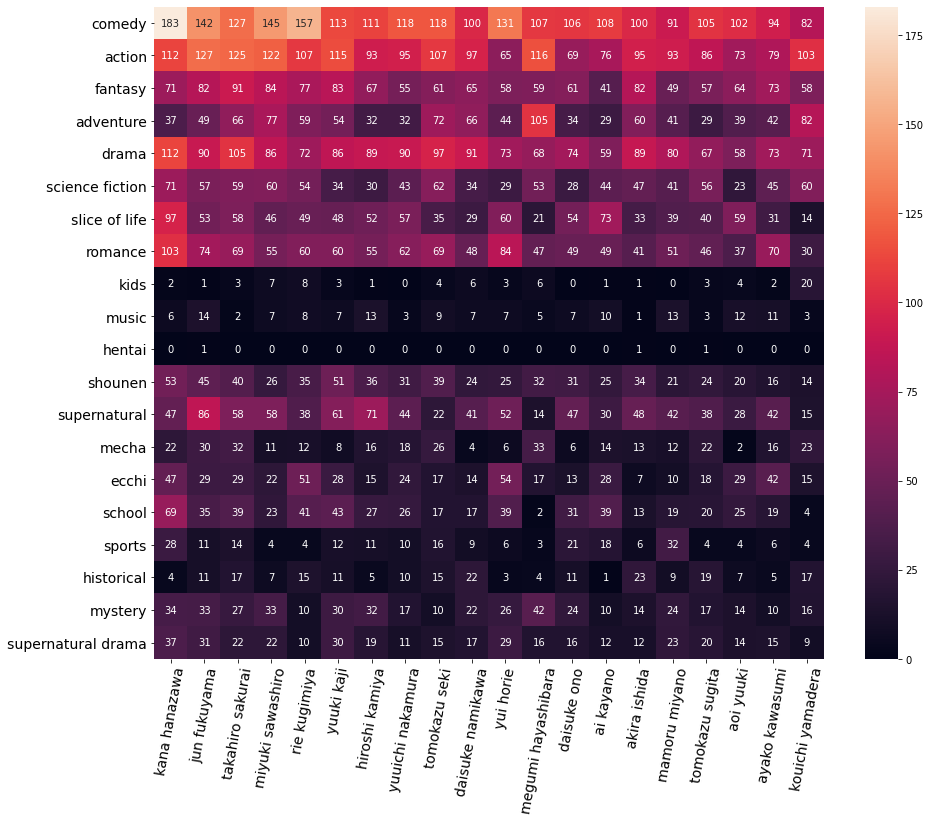

In [12]:
fig = plt.figure(figsize = (15,12))
genre_actor_occurence = attr1_attr2_count(genre_anime_dict, actor_anime_dict, heatmap = True)
plt.savefig('plots/OccurenceHeatmapGenreVsActor.png', bbox_inches = "tight")
plt.show()

## Remarks

* Only a few kid anime are voiced by famous voice actors
> -> Anime for kids have limited budgets, and the targeted audiences (kids) are indifferent about the casts.
* Musics genre has different requirement in voice acting skill.
* Hentai is a sensitive genre, so popular actors would avoid this genre to preserve their reputation. 
>Sidefact: all the 3 names who has worked in hentai anime (Jun Fukuyama, Akira Ishida, Tomokazu Sugita) are Male.

# Average score heatmap

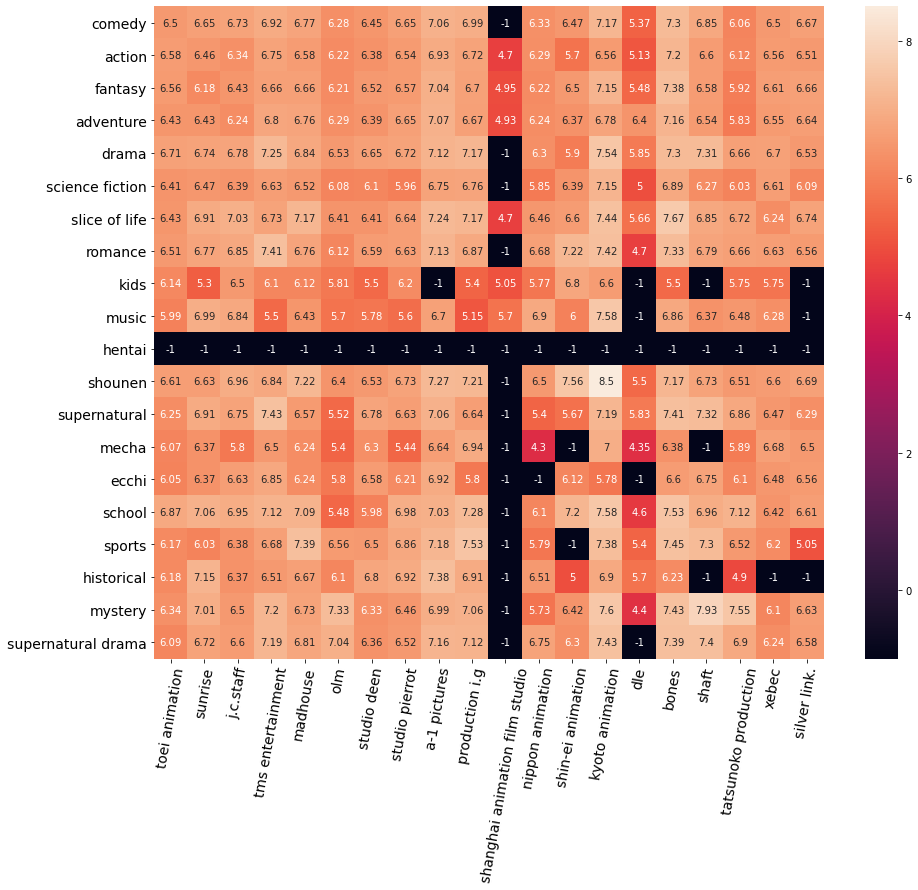

In [13]:
fig = plt.figure(figsize = (15,12))
genre_studio_avg_score = avg_score(genre_anime_dict, studio_anime_dict, heatmap = True)
plt.savefig('plots/AvgScoreHeatmapGenreVsStudio.png', bbox_inches = "tight")
plt.show()

In [14]:
print(genre_studio_occurence['kyoto animation']['shounen'])
print(genre_studio_occurence['shaft']['mystery'])

4
26


Kyoto animation has very high score in shounen (8,5). However, the studio has only made 4 anime of this genre.

Shaft is very successful in mystery. With 26 anime and high average score: 7.93

> <b> We should not only take average score into account. We should also consider the count number.

# Successful score heatmap

## Genre vs Studio

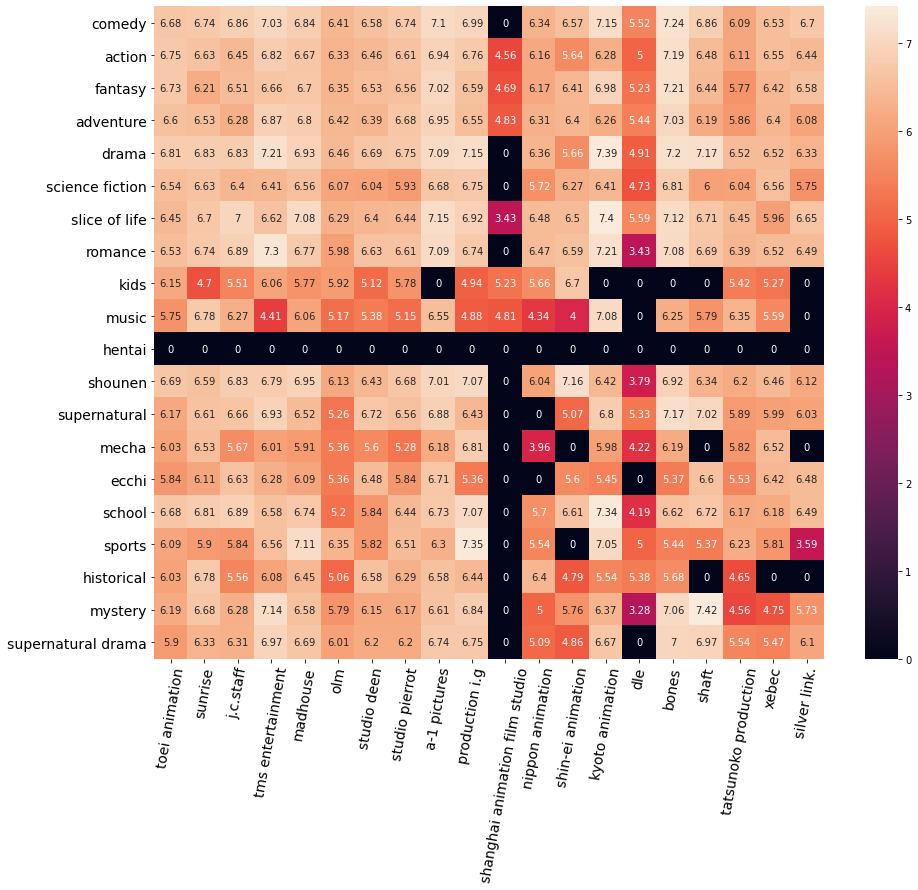

In [15]:
fig = plt.figure(figsize = (15,12))
successful_score(genre_studio_occurence, genre_studio_avg_score, heatmap =True)
plt.savefig('plots/SuccessfulScoreHeatmapGenreVsStudio.png', bbox_inches = "tight")
plt.show()

<b>Noticible studios by genres:</b>
* Drama: madhouse
* Romance: J.C.Staff
* Kids: Shanghai studio, olms
* Music: A-1 picture, Tatsunoko Production

<b>Noticible genres by studios:</b>
* Sunrise: Action, Science fiction, Mecha
* Kyoto Animation: Slice of life, comedy, drama, school

## Actor vs Studio

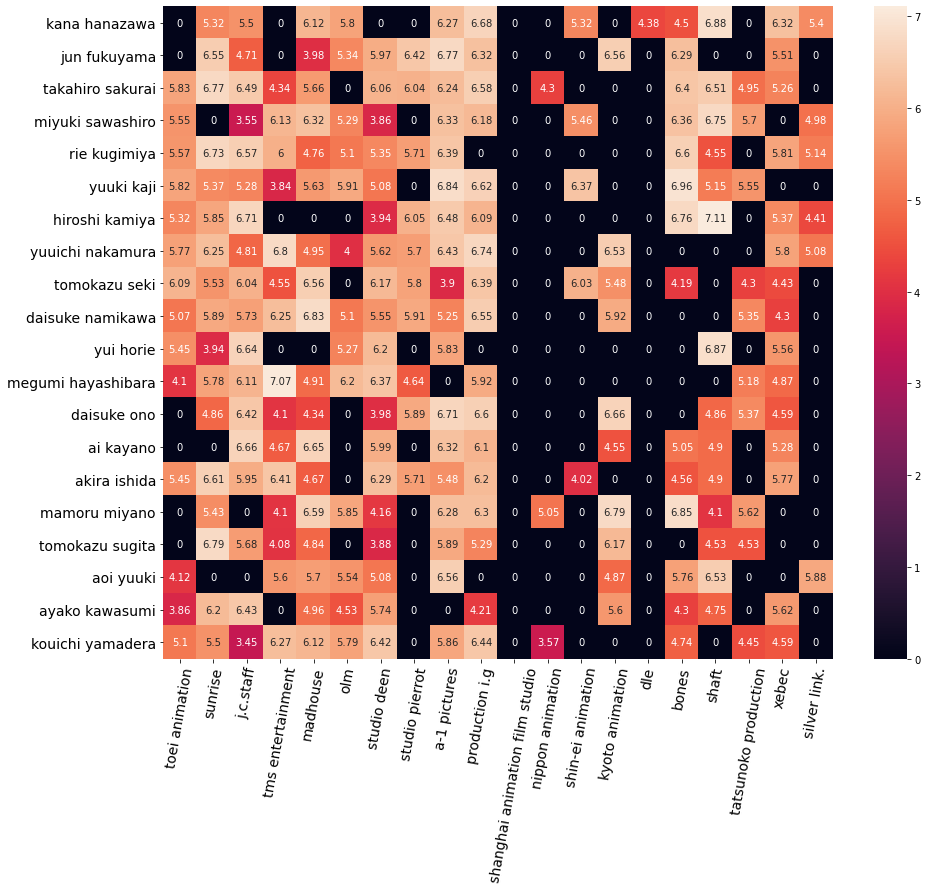

In [16]:
actor_studio_avg_score = avg_score(actor_anime_dict, studio_anime_dict, heatmap = False) #not plot the avg_score heatmap
fig = plt.figure(figsize = (15,12))
successful_score( actor_studio_occurence, actor_studio_avg_score, heatmap = True)
plt.savefig('plots/SuccessfulScoreHeatmapActorVsStudio.png', bbox_inches = "tight")
plt.show()

<b>Noticible pairs</b>
* Ai Yakano & JCStaff
* Megumi Hayashibara & tms entertainment
* Jun Fukuyama & A-1 pictures
* Hiroshi Kamiya & Shaft

## Genre vs Actor

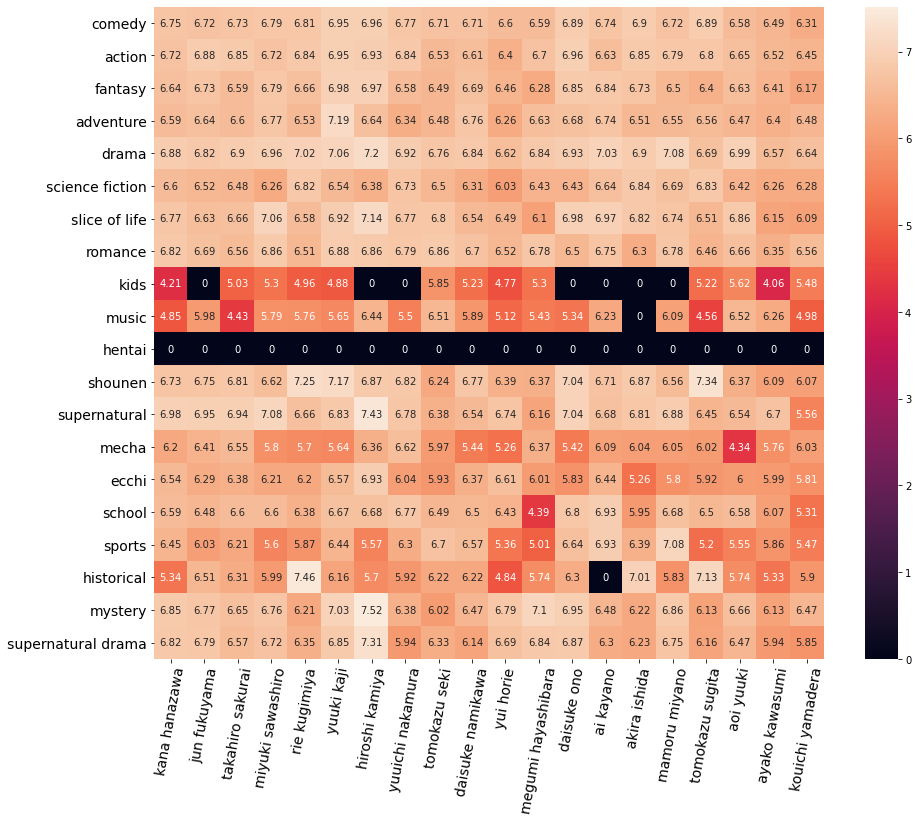

In [17]:
genre_actor_avg_score = avg_score(genre_anime_dict, actor_anime_dict, heatmap = False) #not plot the avg_score heatmap
fig = plt.figure(figsize = (15,12))
successful_score(genre_actor_occurence, genre_actor_avg_score, heatmap = True)
plt.savefig('plots/SuccessfulScoreHeatmapGenreVsActor.png', bbox_inches = "tight")
plt.show()